# Кластеризация пациентов с сердечными заболеваниями.

**Напылов Евгений М22-ИВТ-1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt            
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import trange, tqdm
from pandas.plotting import scatter_matrix

from sklearn.cluster import k_means, kmeans_plusplus

from sklearn.decomposition import PCA

## Data

https://www.kaggle.com/datasets/kingabzpro/heart-disease-patients

- Данные получены из медицинского центра V.A. в Лонг-Бич, Калифорния.
- Есть анонимные данные пациентов, которые имеют проблемы с сердцем.
- Индивидуально подбирать методику лечения сложно, поэтому можно попробовать кластеризовать пациентов на группы на основании симптомов / сердечных метрик.
- В теории каждая группа может иметь свою общую методику лечения.

In [2]:
url = '../data/heart_disease_patients.csv'
data = pd.read_csv(url, sep=',', header=0, engine='python')
data.shape

(303, 12)

In [3]:
data

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,1,63,1,1,145,233,1,2,150,0,2.3,3
1,2,67,1,4,160,286,0,2,108,1,1.5,2
2,3,67,1,4,120,229,0,2,129,1,2.6,2
3,4,37,1,3,130,250,0,0,187,0,3.5,3
4,5,41,0,2,130,204,0,2,172,0,1.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
298,299,45,1,1,110,264,0,0,132,0,1.2,2
299,300,68,1,4,144,193,1,0,141,0,3.4,2
300,301,57,1,4,130,131,0,0,115,1,1.2,2
301,302,57,0,2,130,236,0,2,174,0,0.0,2


In [4]:
print(list(data))

['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']


- id - айди, его дропнем
- age - возраст
- sex - пол
- cp - тип боли в груди
- trestbps - артериальное давление в состоянии покоя (в мм рт. ст. при поступлении в больницу)
- chol - сывороточный холестерин в мг/дл
- fbs - уровень сахара в крови натощак > 120 мг/дл (1 / 0)
- restecg - результаты ЭКГ в состоянии покоя
- thalach - максимальный пульс
- exang - появляется ли стенокардия под физической нагрузкой (1 / 0)
- oldpeak - депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом (что-то из ЭКГ)
- slope - наклон сегмента ST пикового упражнения (что-то из ЭКГ)

In [5]:
data = data.drop(['id'], axis=1)

**Диаграммы рассеивания**

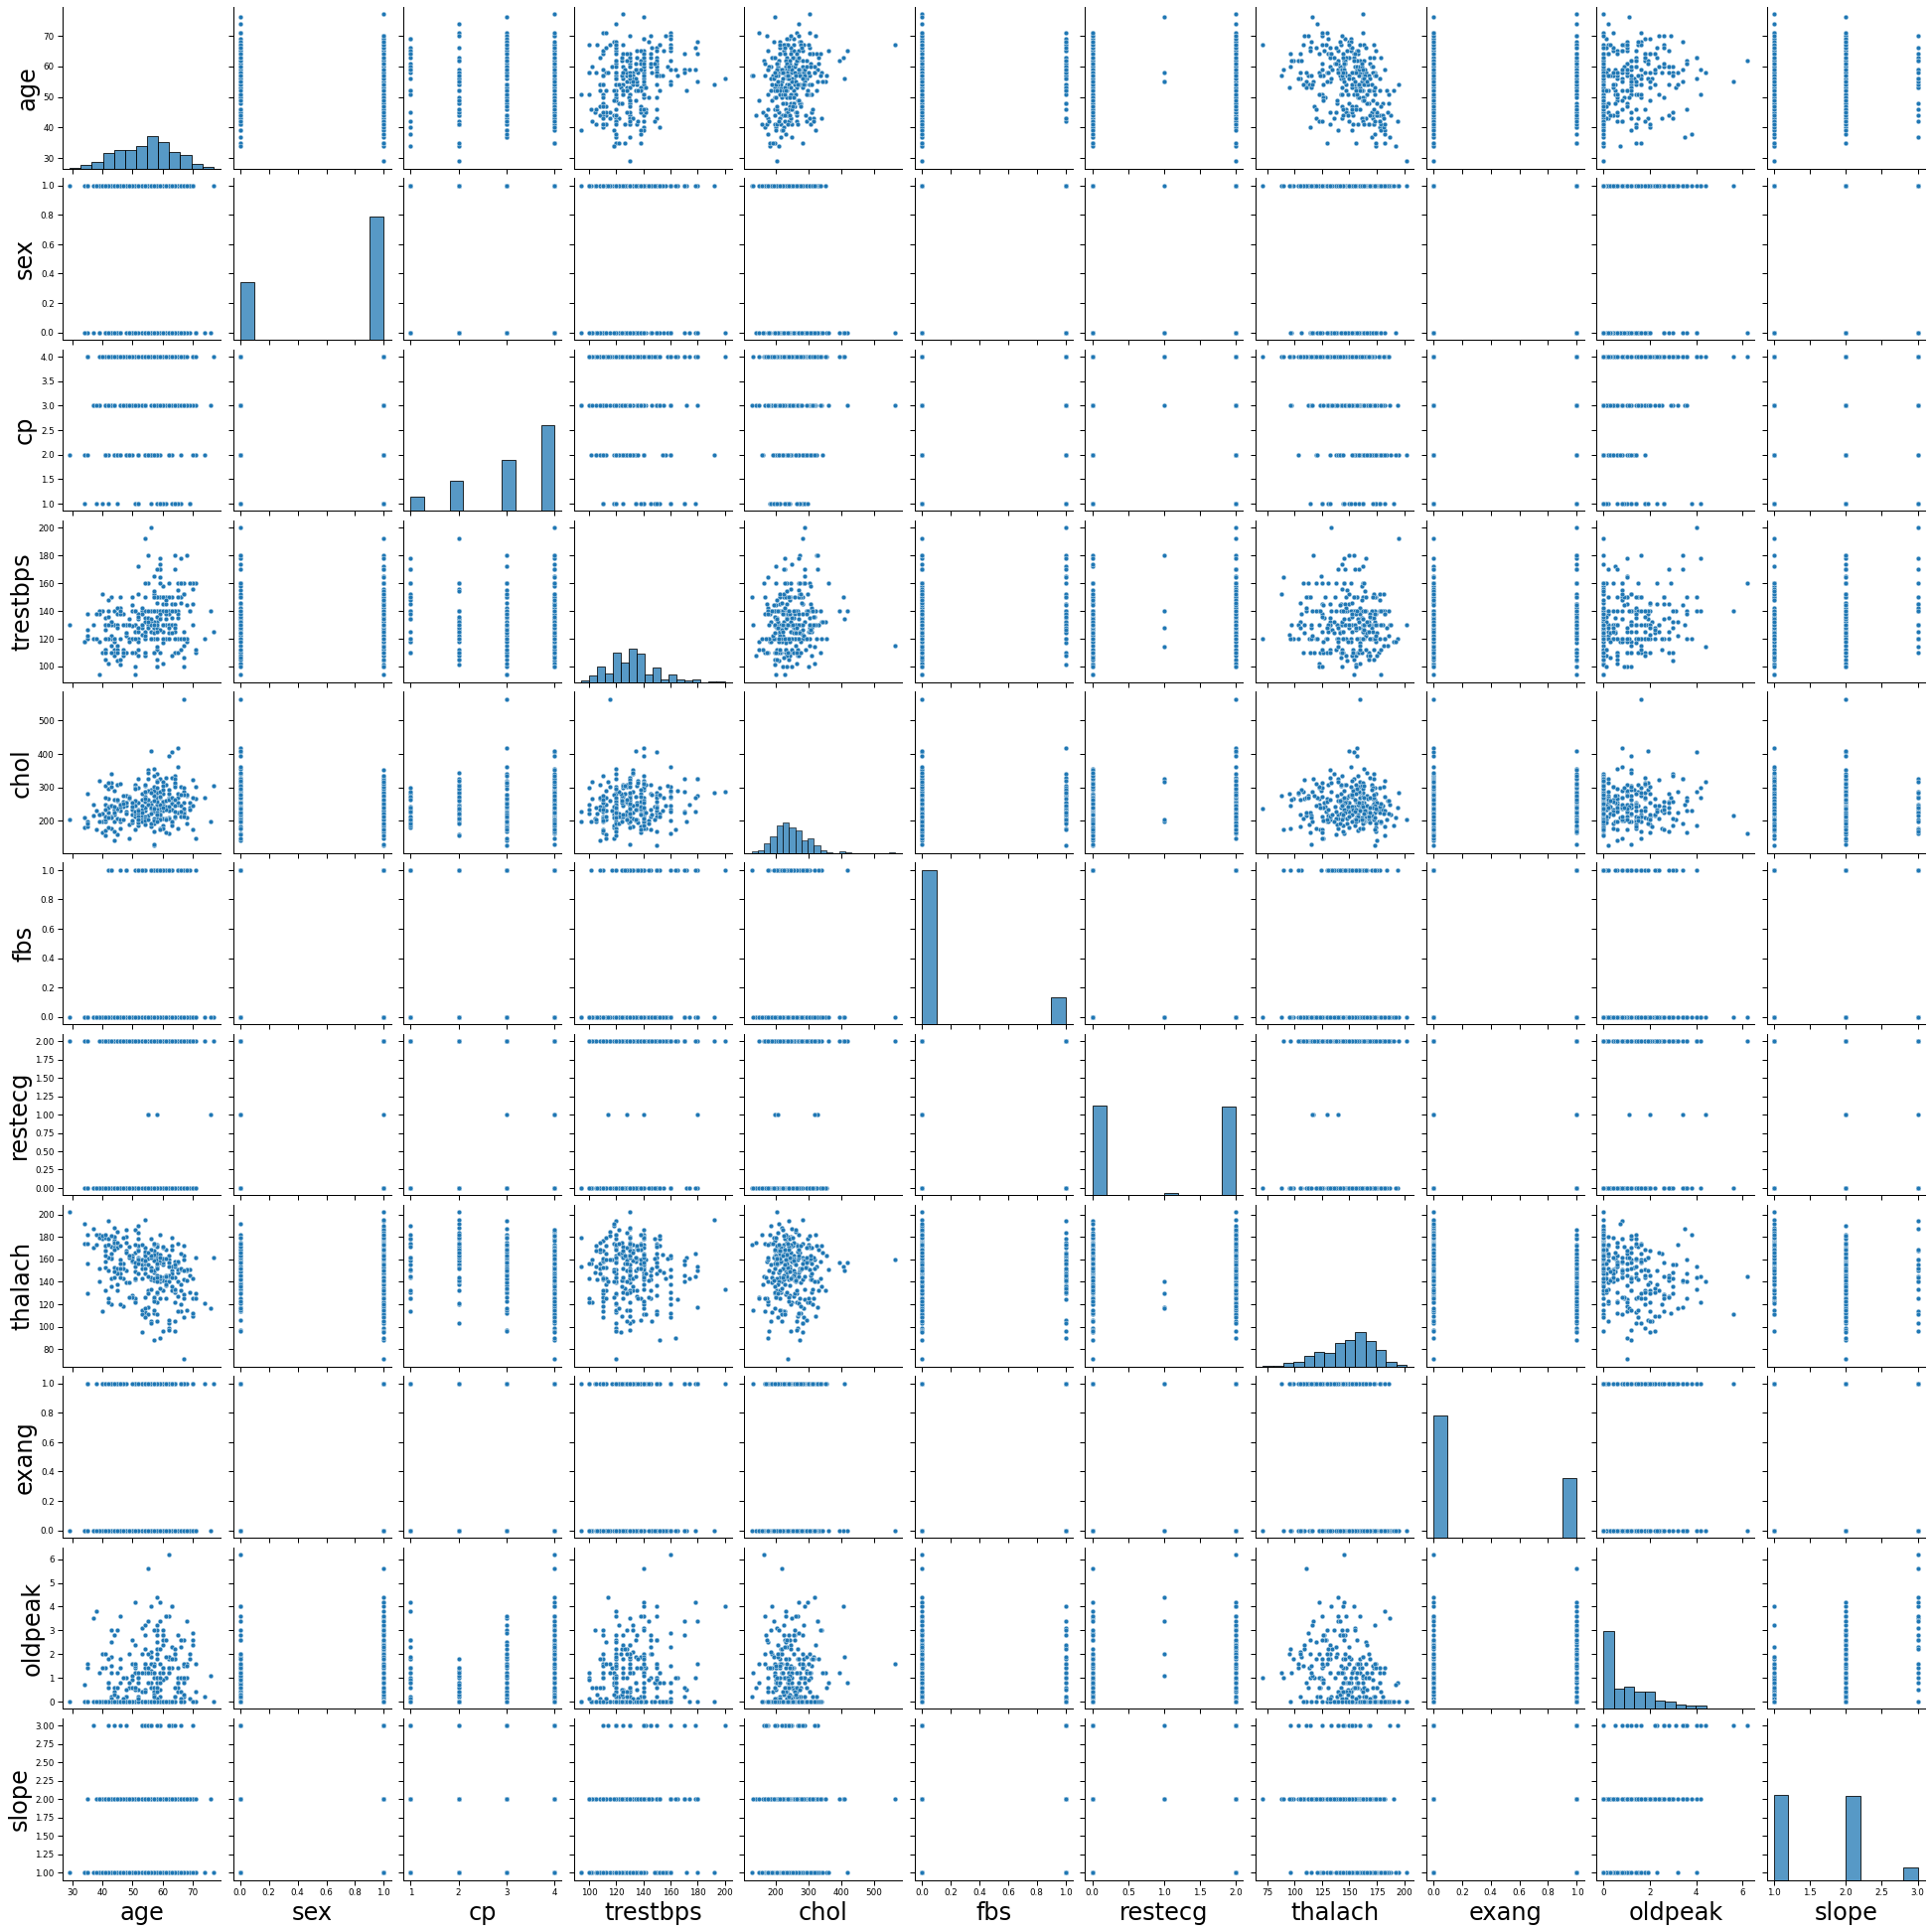

In [6]:
sns.set_context("paper", rc={"axes.labelsize":24})
sns.pairplot(data, diag_kind = 'auto')
pass

**Корреляции**

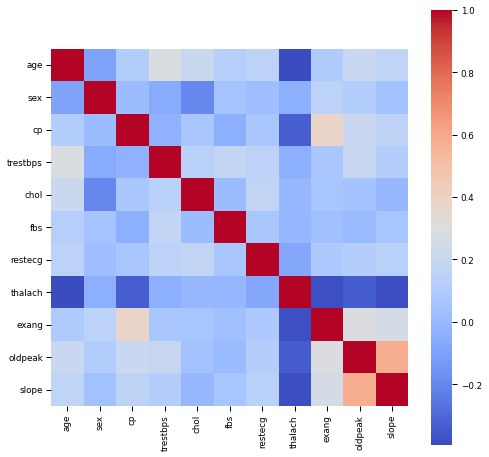

In [7]:
corr_matrix=data.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, square=True, cmap='coolwarm')
pass

Есть немного слабых корреляций и несколько "анти" корреляций.

**Есть ли пропущенные значения?**

In [8]:
data.isna().sum().sum()

0

## Preprocessing

Исходные данные почти идеальны. Единственное, что нужно сделать - нормализовать данные и конвертнуть в np.array

In [9]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,63,1,1,145,233,1,2,150,0,2.3,3
1,67,1,4,160,286,0,2,108,1,1.5,2
2,67,1,4,120,229,0,2,129,1,2.6,2
3,37,1,3,130,250,0,0,187,0,3.5,3
4,41,0,2,130,204,0,2,172,0,1.4,1
...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2
299,68,1,4,144,193,1,0,141,0,3.4,2
300,57,1,4,130,131,0,0,115,1,1.2,2
301,57,0,2,130,236,0,2,174,0,0.0,2


In [10]:
normalized_data=(data-data.min())/(data.max()-data.min())

In [11]:
normalized_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,0.708333,1.0,0.000000,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0
1,0.791667,1.0,1.000000,0.622642,0.365297,0.0,1.0,0.282443,1.0,0.241935,0.5
2,0.791667,1.0,1.000000,0.245283,0.235160,0.0,1.0,0.442748,1.0,0.419355,0.5
3,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.0,0.885496,0.0,0.564516,1.0
4,0.250000,0.0,0.333333,0.339623,0.178082,0.0,1.0,0.770992,0.0,0.225806,0.0
...,...,...,...,...,...,...,...,...,...,...,...
298,0.333333,1.0,0.000000,0.150943,0.315068,0.0,0.0,0.465649,0.0,0.193548,0.5
299,0.812500,1.0,1.000000,0.471698,0.152968,1.0,0.0,0.534351,0.0,0.548387,0.5
300,0.583333,1.0,1.000000,0.339623,0.011416,0.0,0.0,0.335878,1.0,0.193548,0.5
301,0.583333,0.0,0.333333,0.339623,0.251142,0.0,1.0,0.786260,0.0,0.000000,0.5


In [12]:
data_np = normalized_data.values

In [13]:
data_np.shape

(303, 11)

In [14]:
data_np

array([[0.70833333, 1.        , 0.        , ..., 0.        , 0.37096774,
        1.        ],
       [0.79166667, 1.        , 1.        , ..., 1.        , 0.24193548,
        0.5       ],
       [0.79166667, 1.        , 1.        , ..., 1.        , 0.41935484,
        0.5       ],
       ...,
       [0.58333333, 1.        , 1.        , ..., 1.        , 0.19354839,
        0.5       ],
       [0.58333333, 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.5       ],
       [0.1875    , 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ]])

## K-means

Как же выбрать число кластеров? Попробую подобрать по падению инерций (сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся).

In [15]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 25

!!! В sklearn k-means по дефолту использует инициализацию kmeans++. Чтобы использовать классический k-means, необходимо поставить init='random'.

Text(0, 0.5, 'inertia')

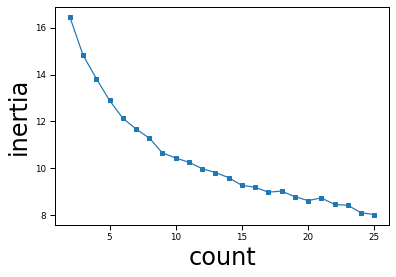

In [30]:
inertia = []
for k in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    kmeans = k_means(X=data_np, n_clusters=k, init='random') # -> (centroid, label, inertia)
    inertia.append(np.sqrt(kmeans[2]))

plt.plot(range(MIN_CLUSTERS, MAX_CLUSTERS+1), inertia, marker='s');
plt.xlabel('count')
plt.ylabel('inertia')

На мой взгляд, можно взять 9 кластеров.

In [32]:
kmeans = k_means(X=data_np, n_clusters=9) # -> (centroid, label, inertia)

**Отображение через PCA**

In [33]:
def plot_clusters(data, kmeans_res):
    labels = kmeans_res[1]
    centroids = kmeans_res[0]
    
    colors = ["b", "g", "r", "c", "m", "y", "lightgreen", "silver", "olive", "coral", "linen", "aqua", "indigo", "sienna", "teal"]
    if len(set(labels.tolist())) > len(colors):
        raise Exception('Too much clusters!')
    
    pca = PCA(n_components=data.shape[1])
    pca.fit(np.concatenate((data, centroids)))
    projections = pca.transform(data)[:, :2]
    centroids_proj = pca.transform(centroids)[:, :2]
    
    fig, ax = plt.subplots()
    uniq = []
    for i in range(projections.shape[0]):
        if labels[i] not in uniq:
            uniq.append(labels[i])
            ax.scatter(projections[i][0], projections[i][1], color=colors[labels[i]], s=10, label=str(labels[i]))
        else:
            ax.scatter(projections[i][0], projections[i][1], color=colors[labels[i]], s=10)
    for i in range(centroids.shape[0]):
        ax.scatter(centroids_proj[i][0], centroids_proj[i][1], marker='o', s=100, color="black")
        ax.scatter(centroids_proj[i][0], centroids_proj[i][1], marker='*', s=100, color=colors[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=1)
    plt.show()

c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


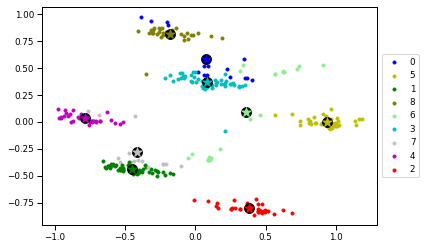

In [34]:
plot_clusters(normalized_data, kmeans)

## K-means++

In [35]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 25

!!! В sklearn k-means по дефолту использует инициализацию kmeans++.

Text(0, 0.5, 'inertia')

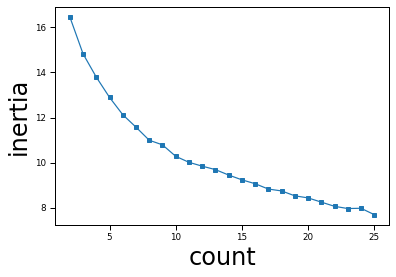

In [36]:
inertia = []
for k in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    kmeans_pp = k_means(X=data_np, n_clusters=k, init='k-means++') # -> (centroid, label, inertia)
    inertia.append(np.sqrt(kmeans_pp[2]))

plt.plot(range(MIN_CLUSTERS, MAX_CLUSTERS+1), inertia, marker='s');
plt.xlabel('count')
plt.ylabel('inertia')

А здесь лучше 10 кластеров

In [37]:
kmeans_pp = k_means(X=data_np, n_clusters=10, init='k-means++') # -> (centroid, label, inertia)

**Отображение через PCA**

c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


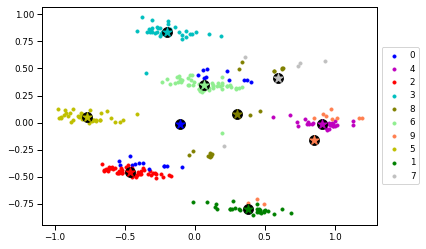

In [38]:
plot_clusters(normalized_data, kmeans_pp)

## Сравнение на одинаковом количестве кластеров

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=2


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


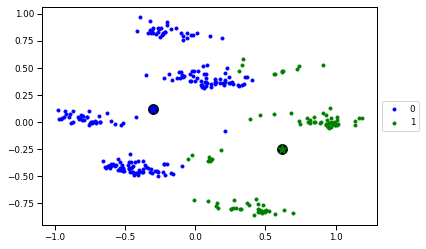

K-means++, k=2


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


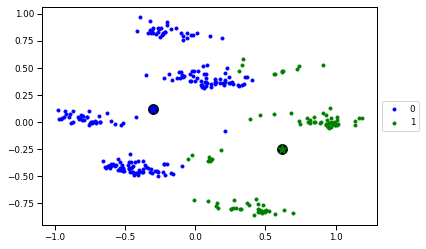

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=3


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


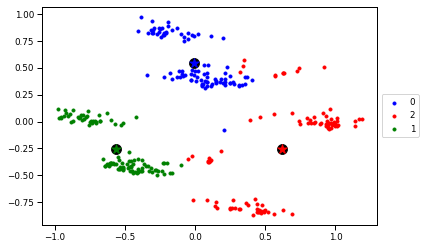

K-means++, k=3


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


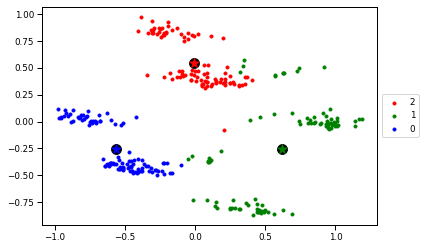

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=4


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


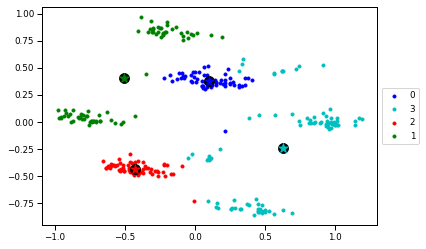

K-means++, k=4


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


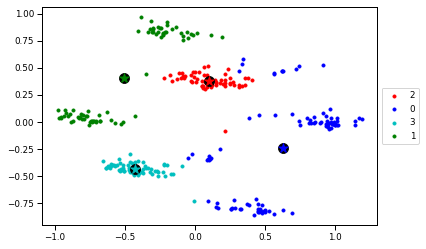

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=5


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


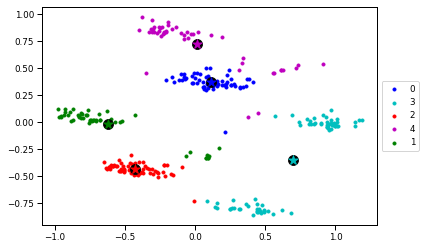

K-means++, k=5


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


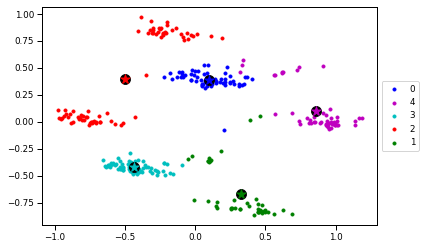

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=6


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


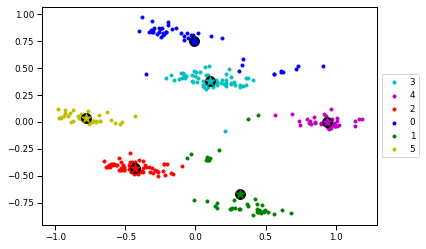

K-means++, k=6


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


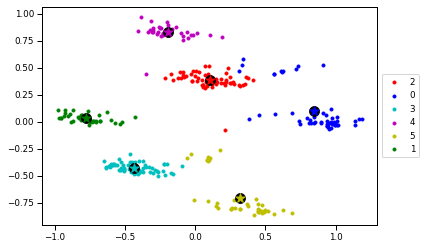

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=7


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


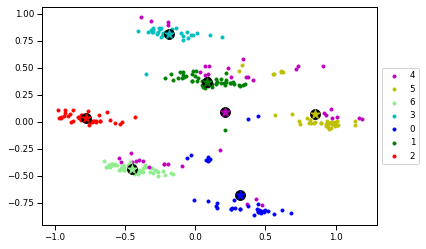

K-means++, k=7


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


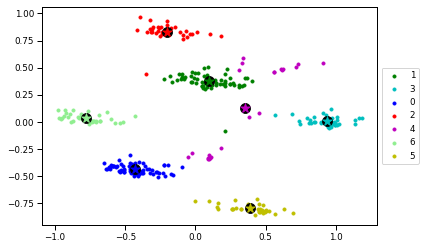

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=8


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


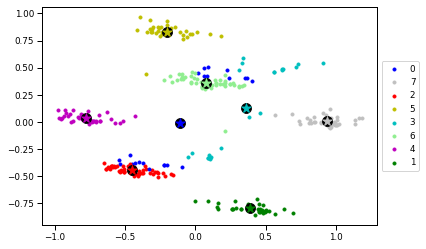

K-means++, k=8


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


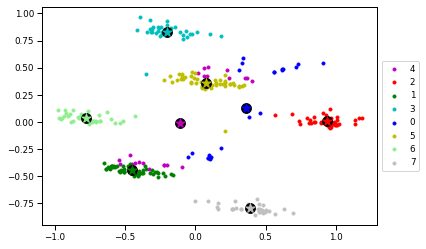

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=9


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


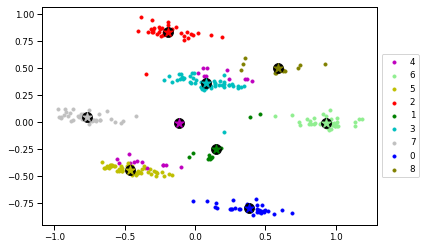

K-means++, k=9


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


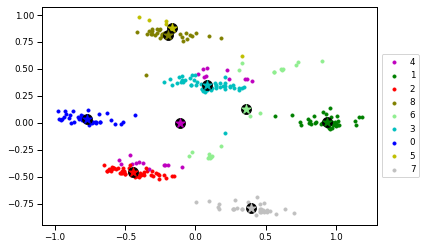

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=10


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


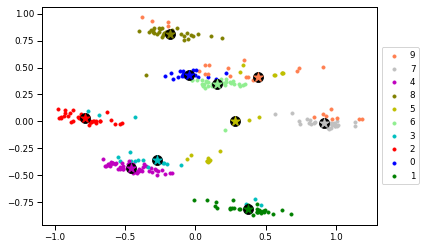

K-means++, k=10


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


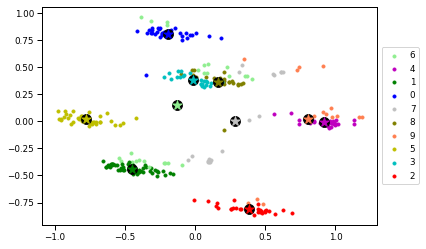

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=11


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


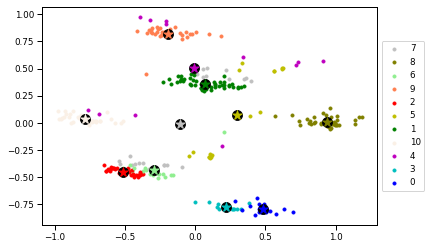

K-means++, k=11


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


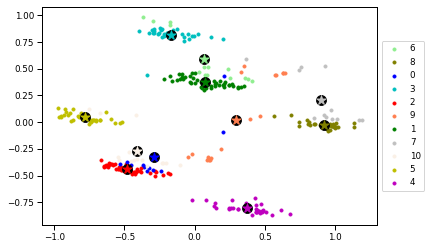

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=12


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


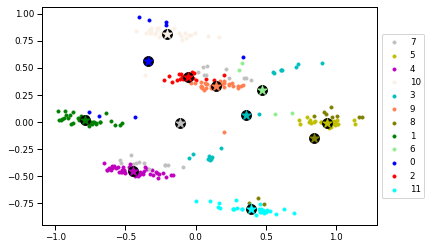

K-means++, k=12


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


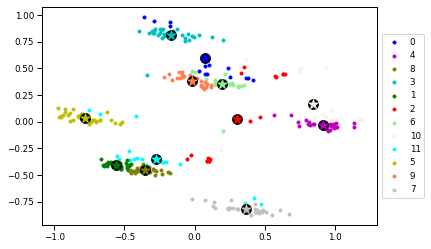

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=13


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


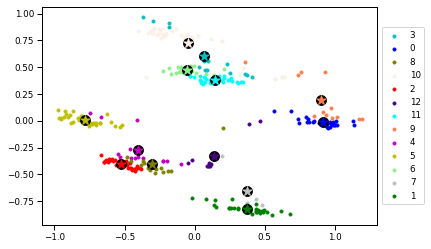

K-means++, k=13


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


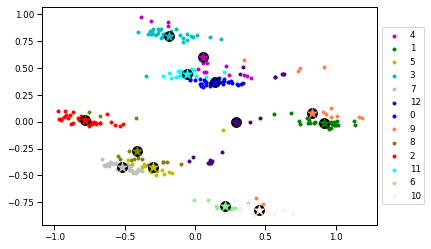

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=14


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


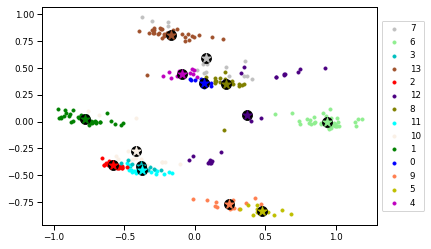

K-means++, k=14


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


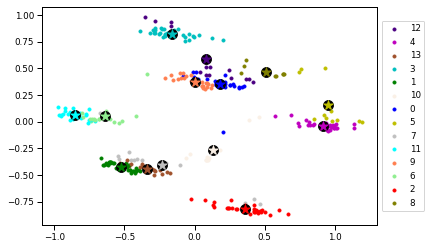

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
K-means, k=15


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


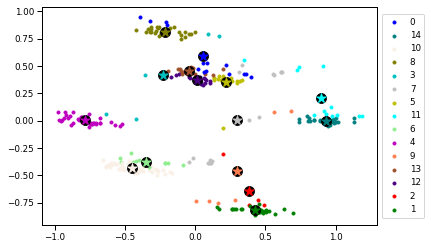

K-means++, k=15


c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


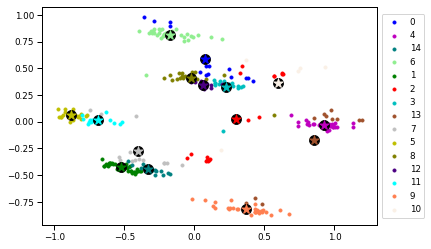

In [42]:
for k in range(2, 15+1):
    print('------------------------------------------------------------')
    print('------------------------------------------------------------')
    print('------------------------------------------------------------')
    print(f'K-means, k={k}')
    plot_clusters(normalized_data, k_means(X=data_np, n_clusters=k, init='random'))
    print(f'K-means++, k={k}')
    plot_clusters(normalized_data, k_means(X=data_np, n_clusters=k, init='k-means++'))